# 2nd-order acoustic with horizontal free-surface

In this notebook, the process of implementing a horizontal free-surface immersed boundary in Devito using Schism is shown. The boundary is located half a grid increment above index 50.

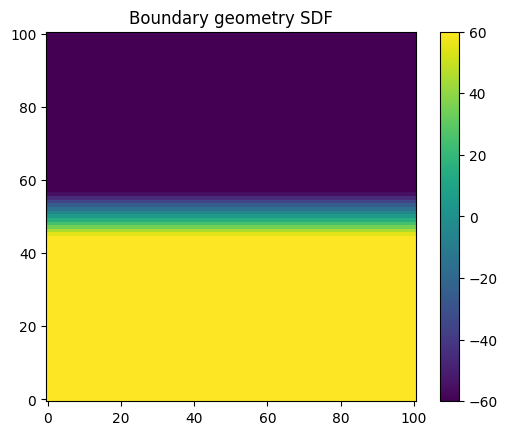

In [1]:
# Load the signed distance function for the boundary geometry
import pickle
import matplotlib.pyplot as plt

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = '../tests/sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the flat 2D sdf
sdf = read_sdf('horizontal', 2)

plt.imshow(sdf.data.T, origin='lower')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

With a discretized signed distance function (SDF) as a Devito `Function`, a `BoundaryGeometry` object can be constructed. This carries out various calculations relating to the surface geometry and stores some attributes.

In [2]:
from schism import BoundaryGeometry

bg = BoundaryGeometry(sdf)
grid = bg.grid  # Gets the grid from the signed distance function

Operator `normals` ran in 0.01 s


This object uses the SDF to calculate boundary locations, normals, and distance to the boundary from each point. It also carries out interior-exterior sectioning and identifies grid points which are boundary-adjacent.

Next a `TimeFunction` is defined to represent pressure.

In [3]:
import devito as dv

s_o = 4
p = dv.TimeFunction(name='p', grid=grid, space_order=s_o, time_order=2)

With this, boundary conditions to be imposed on the surface can be defined. This is done by creating a list of equalities to hold on the surface as Devito `Eq` and passing those to a `BoundaryConditions` object.

In [4]:
from schism import BoundaryConditions

bc_list = [dv.Eq(p, 0),  # Zero pressure on free surface
           dv.Eq(p.dx2+p.dy2, 0),  # Zero laplacian
           dv.Eq(p.dx4 + 2*p.dx2dy2 + p.dy4, 0)]  # Zero biharmonic

bcs = BoundaryConditions(bc_list)

In the case of the acoustic free surface for pressure, pressure is set to zero. By substituting this into the equation, we can obtain higher-order boundary conditions in the form of the laplacian of pressure, the biharmonic, and so forth. Under the hood, `BoundaryConditions` parses and sorts the expressions supplied.

With this, we can assemble our `Boundary`

In [5]:
from schism import Boundary

boundary = Boundary(bcs, bg)

To get substitutions for required derivative expressions, one passes a tuple of `Derivative` objects for which these stencils are required to `Boundary.substitutions()`. In the case of a horizontal boundary with the acoustic free surface, the `p.dx2` derivative stencil will require replacement.

In [6]:
deriv = (p.dy2,)
subs = boundary.substitutions(deriv)

Generating stencils for Derivative(p(t, x, y), (y, 2))


This yields a dictionary containing the modified stencil expressions, keyed with the derivatives that they replace. This can then be used to form the wave equation.

Before this however, a sponge layer around the edges of the domain will be set up.

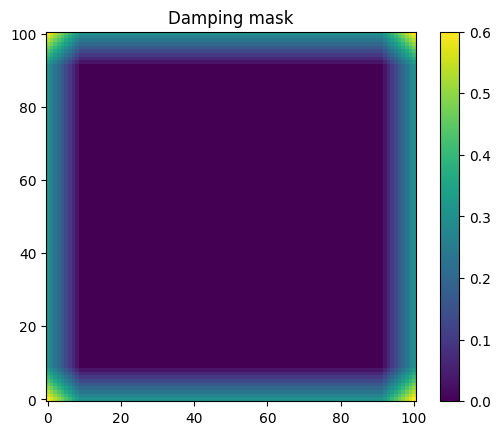

In [7]:
import numpy as np

damp = dv.Function(name='damp', grid=grid)

# Number of boundary layers
nbl = 10
taper = np.linspace(0, 0.3, nbl)

# Add the taper to the function's data
damp.data[:10] += taper[::-1, np.newaxis]
damp.data[-10:] += taper[:, np.newaxis]
damp.data[:, :10] += taper[np.newaxis, ::-1]
damp.data[:, -10:] += taper[np.newaxis, :]

plt.imshow(damp.data.T, origin='lower')
plt.title("Damping mask")
plt.colorbar()
plt.show()

A source term is also specified.

In [8]:
from examples.seismic import TimeAxis, RickerSource

c = 1

t0 = 0.  # Simulation starts a t=0
tn = 550.  # Simulation last 0.55 seconds (550 ms)
dt = 0.5*10/c  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.008  # Source peak frequency is 8Hz (0.008 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions
src.coordinates.data[0, :] = np.array(grid.extent) * .5
src.coordinates.data[0, -1] = 250.  # 250m above bottom

Writing the wave equation with damping terms:

In [9]:
eq = dv.Eq(p.forward, 2*p-p.backward+dt**2*c**2*(p.dx2+subs[p.dy2])+damp*p.dt)

Note that one could alternatively replace `subs[p.dx2]` and use the `.subs(subs)` method on the symbolic expression to use the modified derivative stencils.

Then we can create the source injection term.

In [10]:
src_term = src.inject(field=p.forward, expr=c*src*dt**2)

The operator is formed and run.

In [11]:
op = dv.Operator([eq] + src_term)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.008874000000000007, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=5.999999999999999e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

And finally the result is plotted.

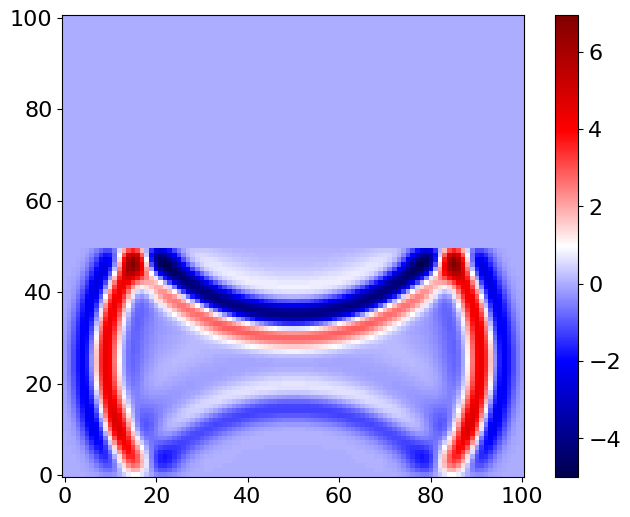

In [12]:
plt.imshow(p.data[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

We can see that the reflected geometry here is as expected.

In [13]:
assert np.isclose(np.linalg.norm(p.data), 202.92722)